<a href="https://colab.research.google.com/github/FrenitaFernandes/eye_disease_project/blob/main/eye%20disease%20detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# 1. Import necessary libraries
import tensorflow as tf
import zipfile
import os
from PIL import Image
import matplotlib.pyplot as plt

In [5]:
# 2. Mount Google Drive (if using Colab)
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Mounted at /content/drive


In [6]:
# 3. Extract ZIP file
zip_path = '/content/drive/MyDrive/Frenita (1)/eyeimage.zip'
extract_path = '/content/eyeimage'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Extraction complete.")

Extraction complete.


In [7]:
# 4. Remove extra 'eyeimage' folder if it exists inside /content/eyeimage/eyeimage
extra_folder = '/content/eyeimage/eyeimage/eyeimage'
if os.path.exists(extra_folder):
    import shutil
    shutil.rmtree(extra_folder)
    print("Removed extra 'eyeimage' folder.")

In [8]:
# 5. Clean non-image files (optional, but safe)
def clean_image_folder(folder):
    removed = 0
    for root, dirs, files in os.walk(folder):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()
            except Exception:
                os.remove(file_path)
                removed += 1
    print(f"Removed {removed} non-image files.")

clean_image_folder('/content/eyeimage/eyeimage')


Removed 0 non-image files.


In [9]:

IMAGE_SIZE = 300  # EfficientNetB3 default
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 30

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/eyeimage/eyeimage',
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),  # use your variable here
    batch_size=BATCH_SIZE,                # and here
    label_mode='int'
)


Found 4217 files belonging to 4 classes.


In [10]:
# 7. Check class names and number of files
class_names = dataset.class_names
print(class_names)

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']


In [11]:
len(dataset)

132

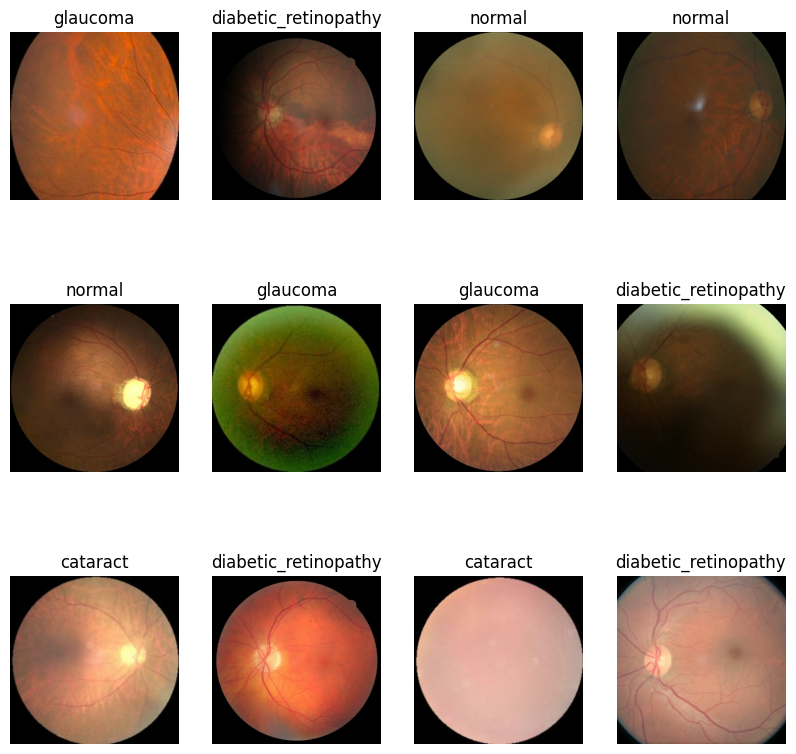

In [12]:
# Visualize a batch before normalization
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
plt.show()

In [13]:
# Add normalization as a preprocessing layer in your model
from tensorflow.keras import layers
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255)
])

Original min/max: 0.0 255.0
Rescaled min/max: 0.0 1.0


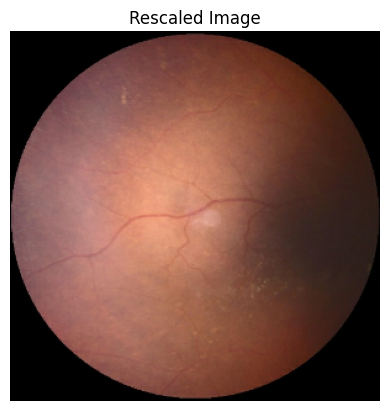

In [14]:
#Visualization after normalizing
# Take a batch from your dataset
for image_batch, label_batch in dataset.take(1):
    # Pass the batch through the resize_and_rescale layer
    rescaled_images = resize_and_rescale(image_batch)
    print("Original min/max:", image_batch.numpy().min(), image_batch.numpy().max())
    print("Rescaled min/max:", rescaled_images.numpy().min(), rescaled_images.numpy().max())

    # Visualize a rescaled image (values will be between 0 and 1)
    import matplotlib.pyplot as plt
    plt.imshow(rescaled_images[0].numpy())
    plt.title("Rescaled Image")
    plt.axis("off")
    plt.show()
    break

In [15]:
!pip install split-folders

In [16]:
import splitfolders

# Set your input and output folder paths
input_folder = "/content/eyeimage/eyeimage"      # Folder with your class subfolders
output_folder = "/content/eyeimage_split"        # New folder to store split data

# Split with 80% training, 10% validation, 10% testing
splitfolders.ratio(
    input_folder,
    output=output_folder,
    seed=42,
    ratio=(.8, .1, .1),    # 80% train, 10% val, 10% test
    group_prefix=None
)

Copying files: 4217 files [00:03, 1243.81 files/s]


In [17]:

#Visualizing train images,test images and validate images
import os

def count_images(folder):
    total = 0
    for class_folder in os.listdir(folder):
        class_path = os.path.join(folder, class_folder)
        if os.path.isdir(class_path):
            total += len(os.listdir(class_path))
    return total

base_path = "/content/eyeimage_split"
for split in ["train", "val", "test"]:
    split_path = os.path.join(base_path, split)
    print(f"{split.capitalize()} images:", count_images(split_path))

Train images: 3372
Val images: 419
Test images: 426


In [18]:
# Load each split from its folder
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/eyeimage_split/train',
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='int'
)
# val_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     "/content/eyeimage_split/val",
#     image_size=(IMAGE_SIZE, IMAGE_SIZE),
#     batch_size=BATCH_SIZE,
#     shuffle=True
# )
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/eyeimage_split/val',
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='int'
)
# test_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     "/content/eyeimage_split/test",
#     image_size=(IMAGE_SIZE, IMAGE_SIZE),
#     batch_size=BATCH_SIZE,
#     shuffle=True
# )
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/eyeimage_split/test',
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='int'
)
# To check the number of batches in each split
print("Train batches:", len(train_ds))
print("Validation batches:", len(val_ds))
print("Test batches:", len(test_ds))

Found 3372 files belonging to 4 classes.
Found 419 files belonging to 4 classes.
Found 426 files belonging to 4 classes.
Train batches: 106
Validation batches: 14
Test batches: 14


In [ ]:
##5.Data Augmentation (optional but recommended)

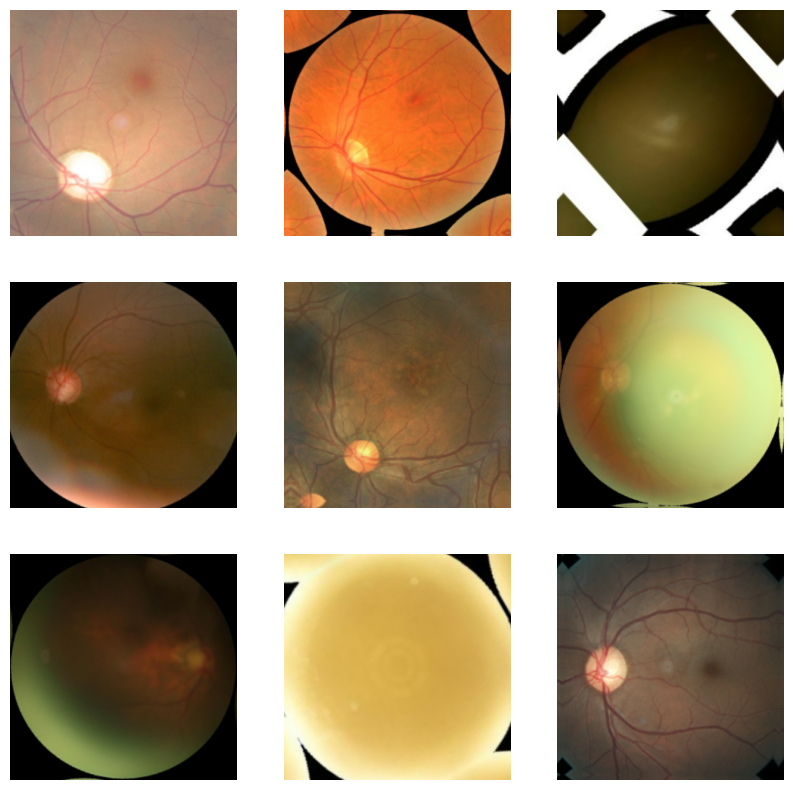

In [19]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
])

# Example: Apply augmentation to a batch from train_ds and visualize
import matplotlib.pyplot as plt

for images, labels in train_ds.take(1):
    augmented_images = data_augmentation(images)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.axis("off")
    plt.show()
    break

In [20]:
##6.Model training which is best for this dataset

In [20]:
import tensorflow as tf
from tensorflow.keras import layers, models
def build_model(base_model):
    base_model.trainable = False  # Freeze the base model
    model = models.Sequential([
        layers.Rescaling(1./255, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(4, activation='softmax')  # 4 classes
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [21]:
# Data augmentation for better generalization
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

In [22]:
# EfficientNetB3 model building function
def build_efficientnetb3_model():
    base_model = tf.keras.applications.EfficientNetB3(
        include_top=False,
        weights='imagenet',
        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)
    )
    base_model.trainable = False  # Freeze base model

    model = models.Sequential([
        layers.Rescaling(1./255, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
        data_augmentation,
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(4, activation='softmax')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

efficientnetb3_model = build_efficientnetb3_model()
efficientnetb3_model.summary()

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 10, 10, 1536)   │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,178,035 (42.64 MB)

 Trainable params: 394,500 (1.50 MB)

 Non-trainable params: 10,783,535 (41.14 MB)

In [1]:
# ##Train Each Model

# EPOCHS = 15  # You can increase for better results

# print("Training MobileNetV2...")
# history_mobilenet = mobilenet_model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)


# early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# # Then add callbacks=[early_stop] in model.fit(...)

# # print("Training EfficientNetB0...")
# # history_efficientnet = efficientnet_model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)
# # early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# # # Then add callbacks=[early_stop] in model.fit(...)




# #print("Training ResNet50...")
# #history_resnet = resnet_model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

In [ ]:
# EarlyStopping to prevent overfitting
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = efficientnetb3_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 1245s 12s/step - accuracy: 0.2574 - loss: 1.4019 - val_accuracy: 0.3103 - val_loss: 1.3876
Epoch 2/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 1191s 11s/step - accuracy: 0.2592 - loss: 1.3935 - val_accuracy: 0.2458 - val_loss: 1.3854
Epoch 3/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 1235s 11s/step - accuracy: 0.2582 - loss: 1.3877 - val_accuracy: 0.3389 - val_loss: 1.3833
Epoch 4/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 1219s 11s/step - accuracy: 0.2804 - loss: 1.3874 - val_accuracy: 0.2840 - val_loss: 1.3840
Epoch 5/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 1203s 11s/step - accuracy: 0.2712 - loss: 1.3837 - val_accuracy: 0.3317 - val_loss: 1.3803
Epoch 6/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 1198s 11s/step - accuracy: 0.2771 - loss: 1.3823 - val_accuracy: 0.2983 - val_loss: 1.3829
Epoch 7/30
 50/106 ━━━━━━━━━━━━━━━━━━━━ 9:24 10s/step - accuracy: 0.3086 - loss: 1.3721